Author: Soumyadip Mukherjee
Team Name: Soumo275
Team Members: Soumyadip Mukherjee
Leaderboard Rank: 47


# using colour histogram and extratrees calssifier


In [2]:
import zipfile
import os

zip_path = "soil-classification.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("soil-classification")

In [3]:
import os       #histogram
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Paths
TRAIN_DIR = '/content/soil-classification/soil_classification-2025/train'
CSV_FILE = '/content/soil-classification/soil_classification-2025/train_labels.csv'

# Function to extract color histogram features
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Image not found or cannot be read.")
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Compute color histogram
        hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        return hist

    except Exception as e:
        print(f"Error: {image_path} => {e}")
        return None

df = pd.read_csv(CSV_FILE)
features, labels = [], []

for _, row in df.iterrows():
    img_path = os.path.join(TRAIN_DIR, row['image_id'])
    hist = extract_color_histogram(img_path)
    if hist is not None:
        features.append(hist)
        labels.append(row['soil_type'])

# convert to numpy array
features = np.array(features)

# ecoding labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

print("Features shape:", features.shape)
print("Encoded Labels shape:", encoded_labels.shape)

Features shape: (1222, 512)
Encoded Labels shape: (1222,)


In [4]:
from sklearn.model_selection import train_test_split         #95.10%
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

#split
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train Extra Trees Classifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Optional: Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.10%


In [5]:
# from sklearn.model_selection import train_test_split   # 95
# from sklearn.ensemble import RandomForestClassifier

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# # Train Random Forest
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Predict
# y_pred = clf.predict(X_test)

Test Accuracy: 0.9510
Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.95      0.98      0.97       106
   Black Soil       0.88      0.97      0.93        39
    Clay soil       1.00      0.83      0.91        48
     Red soil       0.96      0.98      0.97        52

     accuracy                           0.95       245
    macro avg       0.95      0.94      0.94       245
 weighted avg       0.95      0.95      0.95       245



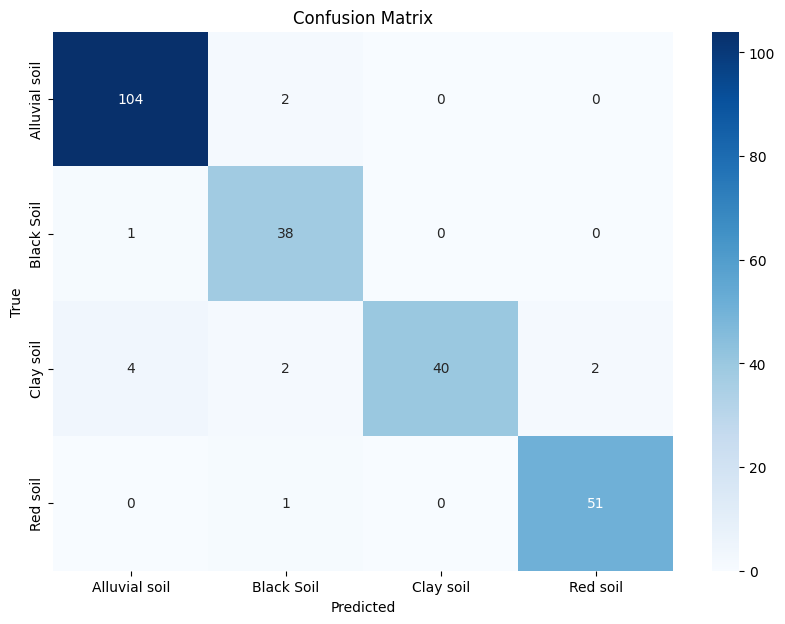

In [6]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# Print classification report for detailed precision, recall, f1-score per class
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
import joblib

# Save the fine-tuned model and label encoder together as a tuple
joblib.dump((clf, le), 'soil_rf_model.joblib')
print("Fine-tuned Model and LabelEncoder saved at 'soil_rf_model.joblib'")

✅ Fine-tuned Model and LabelEncoder saved at 'soil_rf_model.joblib'


In [8]:
import os                     # histogram
import numpy as np
import pandas as pd
import cv2
import joblib

# Paths
IMAGE_FOLDER = '/content/soil-classification/soil_classification-2025/train'
CSV_FILE = '/content/soil-classification/soil_classification-2025/train_labels.csv'
MODEL_FILE = 'soil_rf_model.joblib'
OUTPUT_CSV = '/content/soil-classification/soil_classification-2025/t_input_with_predictions.csv'

# Load model and label encoder
clf, le = joblib.load(MODEL_FILE)
print("Model and LabelEncoder loaded.")

# Load CSV
df = pd.read_csv(CSV_FILE)
predicted_soil_types = []

# Use the same function as in training
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Resize to 224x224 (just like training)
    img_resized = cv2.resize(image, (224, 224))
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    # Compute 3D color histogram without masking black pixels
    hist = cv2.calcHist([img_rgb], [0, 1, 2], None, bins, [0, 256] * 3)
    hist = cv2.normalize(hist, hist).flatten()
    return hist

for _, row in df.iterrows():
    image_id = row['image_id']
    image_path = os.path.join(IMAGE_FOLDER, image_id)

    img = cv2.imread(image_path)
    if img is None:
        print(f"[WARNING] Cannot read image: {image_path}")
        predicted_soil_types.append("Unknown")
        continue

    hist_features = extract_color_histogram(img, bins=(8, 8, 8))

    # Reshape to 2D array for prediction
    hist_features = hist_features.reshape(1, -1)

    pred_encoded = clf.predict(hist_features)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]

    print(f"Image: {image_id}, Predicted: {pred_label}")
    predicted_soil_types.append(pred_label)

df['predicted_soil_type'] = predicted_soil_types
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nPredictions written to: {OUTPUT_CSV}")

✅ Model and LabelEncoder loaded.
Image: img_ed005410.jpg, Predicted: Alluvial soil
Image: img_0c5ecd2a.jpg, Predicted: Alluvial soil
Image: img_ed713bb5.jpg, Predicted: Alluvial soil
Image: img_12c58874.jpg, Predicted: Alluvial soil
Image: img_eff357af.jpg, Predicted: Alluvial soil
Image: img_ebbd4d97.jpeg, Predicted: Alluvial soil
Image: img_61a4be9b.jpg, Predicted: Alluvial soil
Image: img_f8ee6267.jpg, Predicted: Alluvial soil
Image: img_903747fa.jpg, Predicted: Alluvial soil
Image: img_be9dc251.jpg, Predicted: Alluvial soil
Image: img_47b2a710.jpg, Predicted: Alluvial soil
Image: img_92d7778b.jpg, Predicted: Alluvial soil
Image: img_db1d9b5f.jpg, Predicted: Alluvial soil
Image: img_6030bc4f.jpg, Predicted: Alluvial soil
Image: img_dfcfbfe0.jpg, Predicted: Alluvial soil
Image: img_74efd1ac.jpg, Predicted: Alluvial soil
Image: img_20987a8c.jpg, Predicted: Alluvial soil
Image: img_1f23d3f3.jpg, Predicted: Alluvial soil
Image: img_320c82e1.jpg, Predicted: Alluvial soil
Image: img_6d534

In [9]:
import pandas as pd

# CSV paths
csv1 = '/content/soil-classification/soil_classification-2025/train_labels.csv'
csv2 = '/content/soil-classification/soil_classification-2025/t_input_with_predictions.csv'

# Load CSVs
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Check row count
if len(df1) != len(df2):
    raise ValueError("CSV files have different number of rows")

# Compare predictions
matches = df1['soil_type'] == df2['predicted_soil_type']
percent_match = matches.sum() / len(matches) * 100
print(f"\nPercentage of correct predictions: {percent_match:.2f}%")

# Print mismatched rows
mismatches = df1[~matches].copy()
mismatches['predicted_soil_type'] = df2.loc[~matches, 'predicted_soil_type']

print("\nMismatched Predictions:")
if mismatches.empty:
    print("All predictions matched.")
else:
    print(mismatches[['image_id', 'soil_type', 'predicted_soil_type']])


✅ Percentage of correct predictions: 99.02%

⚠️ Mismatched Predictions:
              image_id      soil_type predicted_soil_type
309   img_31fafc06.jpg  Alluvial soil          Black Soil
350   img_d4471d29.jpg  Alluvial soil          Black Soil
553   img_bd1bb46a.jpg      Clay soil            Red soil
591   img_b76d9a00.jpg      Clay soil       Alluvial soil
618   img_72f10347.jpg      Clay soil       Alluvial soil
620   img_cf9901a9.jpg      Clay soil       Alluvial soil
651   img_a9eaebac.jpg      Clay soil          Black Soil
701   img_5d65eae8.jpg      Clay soil       Alluvial soil
711   img_7c647425.jpg      Clay soil            Red soil
712   img_ab6e0a7e.jpg      Clay soil          Black Soil
743   img_32af671f.jpg       Red soil          Black Soil
1047  img_fbc9cf4d.jpg     Black Soil       Alluvial soil


In [10]:
import os
import numpy as np
import pandas as pd
import cv2
import joblib

# Paths
IMAGE_FOLDER = '/content/soil-classification/soil_classification-2025/test'
CSV_FILE = '/content/soil-classification/soil_classification-2025/test_ids.csv'
MODEL_FILE = 'soil_rf_model.joblib'
OUTPUT_CSV = '/content/soil-classification/soil_classification-2025/test_input_with_predictions.csv'

# Load model and label encoder
clf, le = joblib.load(MODEL_FILE)
print("✅ Model and LabelEncoder loaded.")

# Load test CSV
df = pd.read_csv(CSV_FILE)

# Feature extraction function exactly as used in training
def extract_color_histogram(image, bins=(8, 8, 8)):
    img_resized = cv2.resize(image, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([img_rgb], [0, 1, 2], None, bins, [0, 256] * 3)
    hist = cv2.normalize(hist, hist).flatten()
    return hist

predicted_soil_types = []

for image_id in df['image_id']:
    image_path = os.path.join(IMAGE_FOLDER, image_id)
    img = cv2.imread(image_path)
    if img is None:
        print(f"[WARNING] Cannot read image: {image_path}")
        predicted_soil_types.append("Unknown")
        continue

    # Extract features the same way as training
    hist_features = extract_color_histogram(img, bins=(8, 8, 8))
    hist_features = hist_features.reshape(1, -1)  # Reshape for prediction

    pred_encoded = clf.predict(hist_features)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]

    print(f"Image: {image_id}, Predicted: {pred_label}")
    predicted_soil_types.append(pred_label)

df['soil_type'] = predicted_soil_types
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nPredictions written to: {OUTPUT_CSV}")

✅ Model and LabelEncoder loaded.
Image: img_cdf80d6f.jpeg, Predicted: Alluvial soil
Image: img_c0142a80.jpg, Predicted: Alluvial soil
Image: img_91168fb0.jpg, Predicted: Alluvial soil
Image: img_9822190f.jpg, Predicted: Alluvial soil
Image: img_e5fc436c.jpeg, Predicted: Alluvial soil
Image: img_3d6e64a1.jpg, Predicted: Alluvial soil
Image: img_ccb81e64.jpeg, Predicted: Alluvial soil
Image: img_9a499fc5.jpeg, Predicted: Alluvial soil
Image: img_b957da08.jpeg, Predicted: Alluvial soil
Image: img_c62bd1a1.jpg, Predicted: Alluvial soil
Image: img_20eba00e.jpg, Predicted: Alluvial soil
Image: img_46a2c139.jpg, Predicted: Alluvial soil
Image: img_f303eb5f.jpg, Predicted: Alluvial soil
Image: img_3ddd1263.jpg, Predicted: Alluvial soil
Image: img_c115ac40.jpg, Predicted: Alluvial soil
Image: img_be60411c.jpeg, Predicted: Alluvial soil
Image: img_887c5e3d.jpg, Predicted: Alluvial soil
Image: img_85ed00e6.jpg, Predicted: Alluvial soil
Image: img_3819f9e3.jpg, Predicted: Alluvial soil
Image: img_